<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/supplementary/APEX_RLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ape-X RLlib

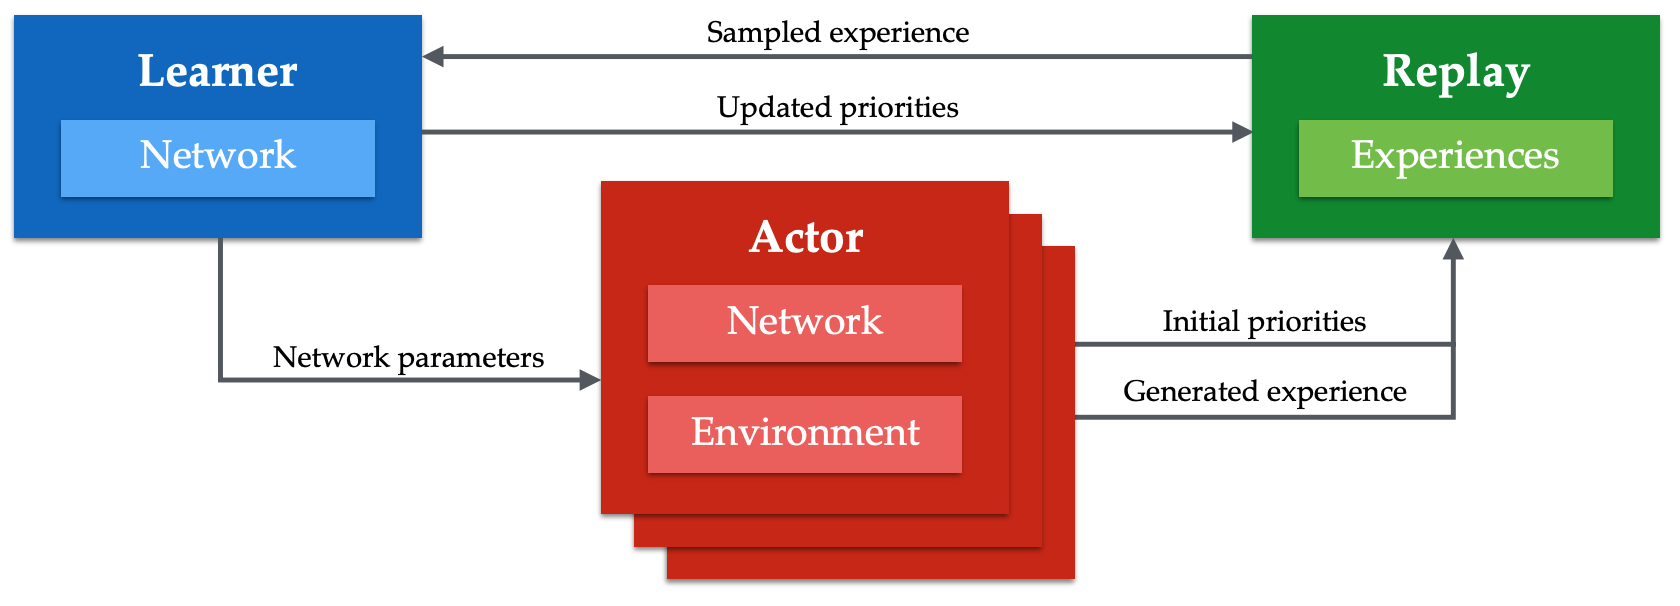

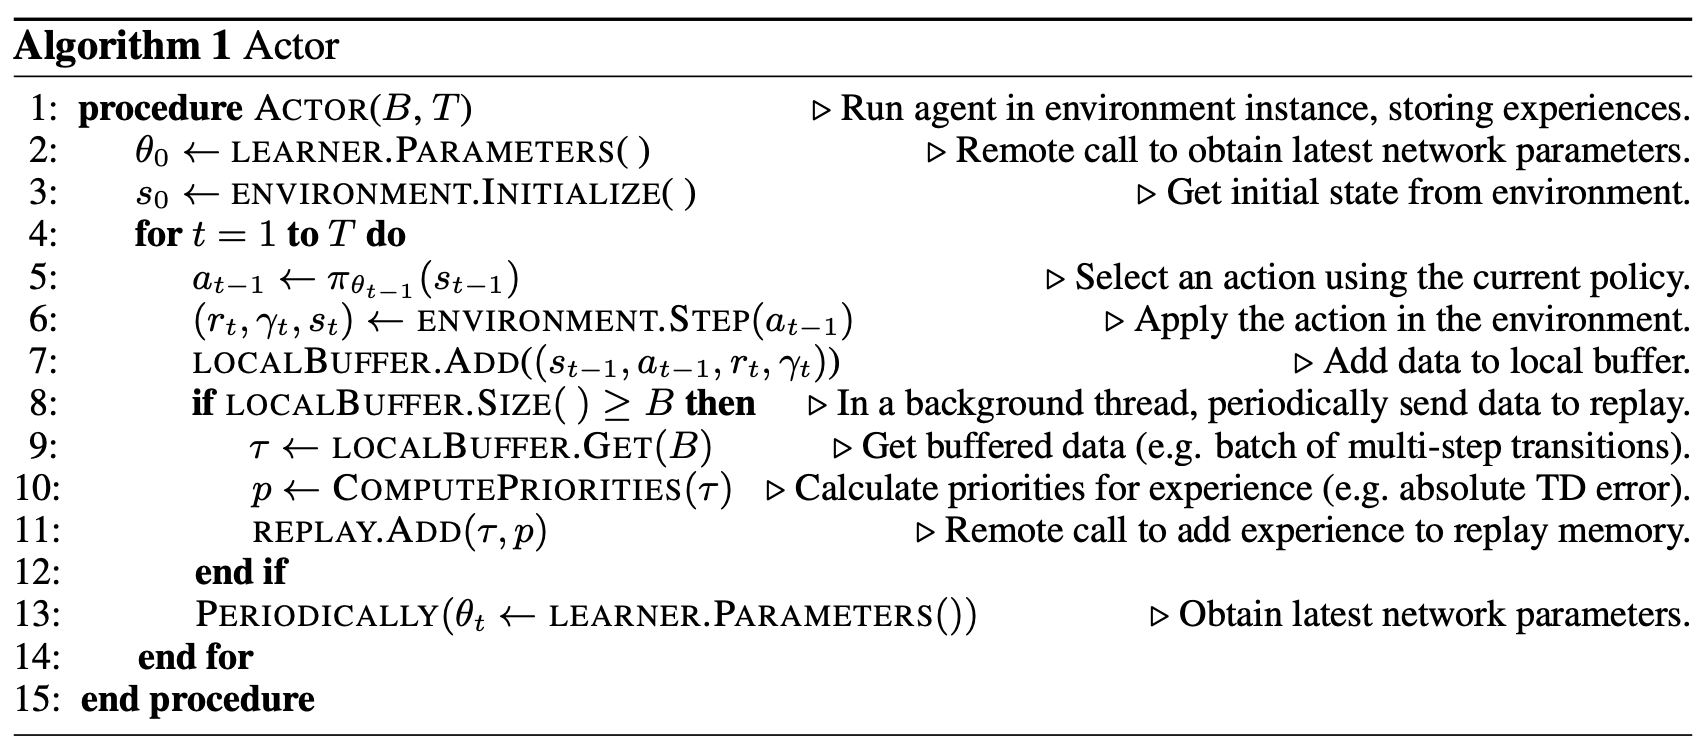

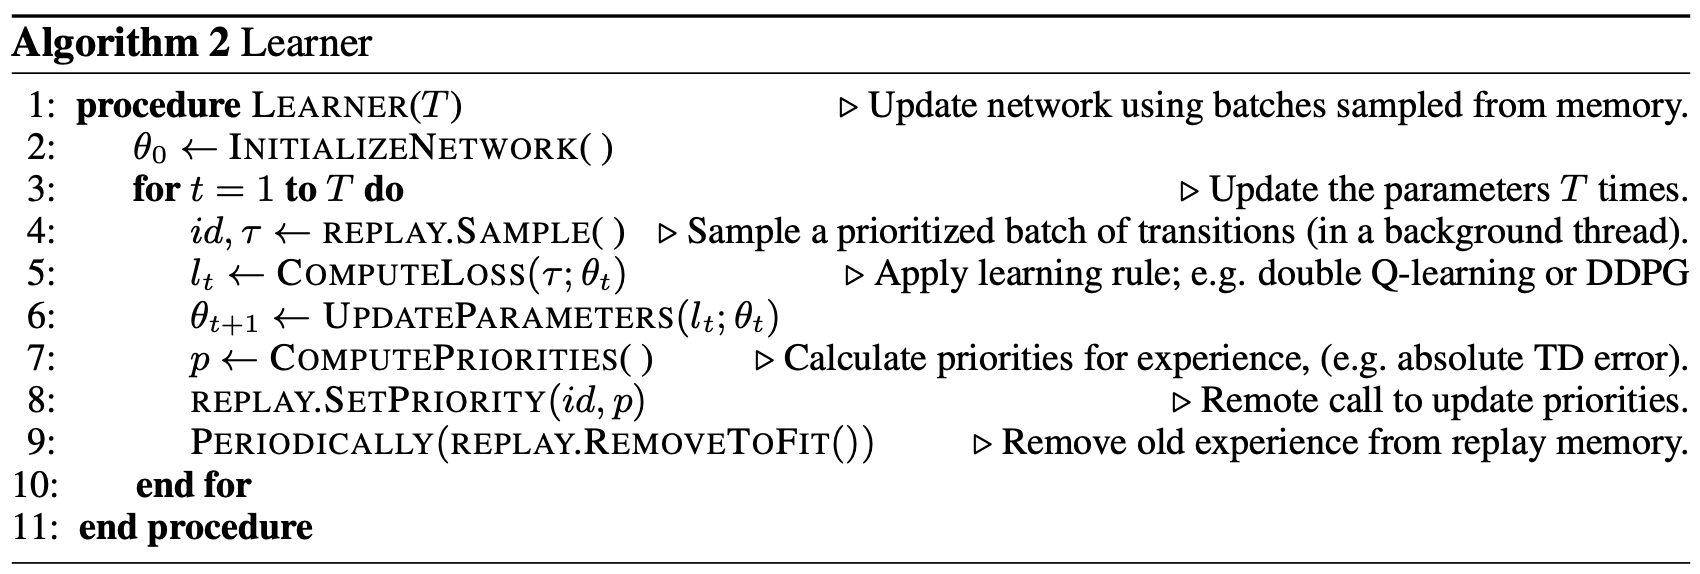

Ape-X에서는 커뮤니케이션 overhead를 줄이기 위해 gradient가 이동하는것 대신에 trajectory가 learner와 actor간에 움직이게 됩니다.

이번 노트북에서는 RLlib에서 Ape-X를 어떻게 구현하였는지 살펴봅니다.

In [ ]:
!pip install ray
!pip install ray[rllib]

Ape-X Trainer를 불러와 Pong 환경을 트레이닝하는 코드입니다.

In [ ]:
import ray
import ray.rllib.agents.dqn.apex as apex
from ray.tune.logger import pretty_print

ray.init()
config = apex.APEX_DEFAULT_CONFIG.copy()
# config["num_gpus"] = 4
config["framework"] = "torch"
config["target_network_update_freq"] = 20000
config["num_workers"] = 32
config["num_envs_per_worker"] = 1
config["lr"] = .00005
config["train_batch_size"] = 64
config["gamma"] = 0.99
trainer = apex.ApexTrainer(config=config, env="PongNoFrameskip-v4")

for i in range(1000000):
    result = trainer.train()
    print(result['episode_reward_mean'])
    #print(result["hist_stats"]["episode_reward"])
    #print(pretty_print(result))

    if i % 100 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)


# Trainer

DQN을 베이스로 하는 Ape-x의 Trainer의 구현은 기존의 DQN 트레이너에서 distributed training을 추가해서 구현이 되어있습니다.

In [5]:
ApexTrainer = DQNTrainer.with_updates(
    name="APEX",
    default_config=APEX_DEFAULT_CONFIG,
    validate_config=apex_validate_config,
    execution_plan=apex_execution_plan,
    mixins=[OverrideDefaultResourceRequest],
)

NameError: ignored

distributed training을 구현한 apex_execution_plan() 함수를 살펴보도록 하겠습니다.

execution_plan()함수는 트레이닝이 어떻게 진행될 것인지 정의해주는 함수이며, WorketSet과 Config를 파라미터로 받아 트레이닝 metric들의 iterator를 리턴해주도록 설계합니다.

다음 코드는 Trainer의 기본으로 설정된 execution_plan() 함수입니다. 함수 안에서는 트레이닝이 바로 실행되지 않고 실행을 어떻게 할 것인지에 대한 operation을 정의해주게 됩니다. operation은 파이썬의 Iterator로 구성되어 있으며 .for_each()함수를 통해 각 iteration에 for_each에 파라미터로 들어가 있는 함수를 적용시켜 줍니다.

```
next(from_range(4).for_each(
                    lambda x: x * 2,
                    max_concur=2,
                    resources={"num_cpus": 0.1}).gather_sync()
    )
            ... [0, 2, 4, 8]
```



In [4]:
def default_execution_plan(workers: WorkerSet, config: TrainerConfigDict):
    # Collects experiences in parallel from multiple RolloutWorker actors.
    rollouts = ParallelRollouts(workers, mode="bulk_sync")

    # Combine experiences batches until we hit `train_batch_size` in size.
    # Then, train the policy on those experiences and update the workers.
    train_op = rollouts.combine(
        ConcatBatches(
            min_batch_size=config["train_batch_size"],
            count_steps_by=config["multiagent"]["count_steps_by"],
        ))

    if config.get("simple_optimizer") is True:
        train_op = train_op.for_each(TrainOneStep(workers))
    else:
        train_op = train_op.for_each(
            TrainTFMultiGPU(
                workers=workers,
                sgd_minibatch_size=config.get("sgd_minibatch_size",
                                              config["train_batch_size"]),
                num_sgd_iter=config.get("num_sgd_iter", 1),
                num_gpus=config["num_gpus"],
                shuffle_sequences=config.get("shuffle_sequences", False),
                _fake_gpus=config["_fake_gpus"],
                framework=config["framework"]))

    # Add on the standard episode reward, etc. metrics reporting. This returns
    # a LocalIterator[metrics_dict] representing metrics for each train step.
    return StandardMetricsReporting(train_op, workers, config)

NameError: ignored

다음은 apex의 execution_plan()을 살펴보겠습니다. 모든 구현코드는 [이곳](https://github.com/ray-project/ray/blob/master/rllib/agents/dqn/apex.py)에서 확인할 수 있습니다.

크게 3가지 operation - store_op, replay_op, update_op를 정의하고, 이 operation들이 Concurret하게 실행될 수 있도록 merged_op를 생성합니다.

store_op : worker들을 사용해서 Rollouts를 만들어 준 후 Rollouts에 actor들이 생성한 Batch(trajectory)를 replay buffer에 넣어주게 됩니다.

replay_op : actor가 생성했던 replay buffer에서 learner의 큐로 옮겨줍니다.

update_op : learner가 트레이닝을 진행하고, 새로 계산된 priority를 다시 actor의 replay buffer로 옮겨 priority를 업데이트 해줍니다



In [ ]:
def apex_execution_plan(workers: WorkerSet,
                        config: dict) -> LocalIterator[dict]:
    # Create a number of replay buffer actors.
    num_replay_buffer_shards = config["optimizer"]["num_replay_buffer_shards"]
    replay_actors = create_colocated(ReplayActor, [
        num_replay_buffer_shards,
        config["learning_starts"],
        config["buffer_size"],
        config["train_batch_size"],
        config["prioritized_replay_alpha"],
        config["prioritized_replay_beta"],
        config["prioritized_replay_eps"],
        config["multiagent"]["replay_mode"],
        config.get("replay_sequence_length", 1),
    ], num_replay_buffer_shards)

    # Start the learner thread.
    learner_thread = LearnerThread(workers.local_worker())
    learner_thread.start()

    # Update experience priorities post learning.
    def update_prio_and_stats(item: Tuple[ActorHandle, dict, int]) -> None:
        actor, prio_dict, count = item
        actor.update_priorities.remote(prio_dict)
        metrics = _get_shared_metrics()
        # Manually update the steps trained counter since the learner thread
        # is executing outside the pipeline.
        metrics.counters[STEPS_TRAINED_COUNTER] += count
        metrics.timers["learner_dequeue"] = learner_thread.queue_timer
        metrics.timers["learner_grad"] = learner_thread.grad_timer
        metrics.timers["learner_overall"] = learner_thread.overall_timer

    # We execute the following steps concurrently:
    # (1) Generate rollouts and store them in one of our replay buffer
    # actors. Update the weights of the worker that generated the batch.
    rollouts = ParallelRollouts(workers, mode="async", num_async=2)
    store_op = rollouts \
        .for_each(StoreToReplayBuffer(actors=replay_actors))
    # Only need to update workers if there are remote workers.
    if workers.remote_workers():
        store_op = store_op.zip_with_source_actor() \
            .for_each(UpdateWorkerWeights(
                learner_thread, workers,
                max_weight_sync_delay=(
                    config["optimizer"]["max_weight_sync_delay"])
            ))

    # (2) Read experiences from one of the replay buffer actors and send to
    # the learner thread via its in-queue.
    post_fn = config.get("before_learn_on_batch") or (lambda b, *a: b)
    replay_op = Replay(actors=replay_actors, num_async=4) \
        .for_each(lambda x: post_fn(x, workers, config)) \
        .zip_with_source_actor() \
        .for_each(Enqueue(learner_thread.inqueue))

    # (3) Get priorities back from learner thread and apply them to the
    # replay buffer actors.
    update_op = Dequeue(
            learner_thread.outqueue, check=learner_thread.is_alive) \
        .for_each(update_prio_and_stats) \
        .for_each(UpdateTargetNetwork(
            workers, config["target_network_update_freq"],
            by_steps_trained=True))

    if config["training_intensity"]:
        # Execute (1), (2) with a fixed intensity ratio.
        rr_weights = calculate_rr_weights(config) + ["*"]
        merged_op = Concurrently(
            [store_op, replay_op, update_op],
            mode="round_robin",
            output_indexes=[2],
            round_robin_weights=rr_weights)
    else:
        # Execute (1), (2), (3) asynchronously as fast as possible. Only output
        # items from (3) since metrics aren't available before then.
        merged_op = Concurrently(
            [store_op, replay_op, update_op], mode="async", output_indexes=[2])

    # Add in extra replay and learner metrics to the training result.
    def add_apex_metrics(result: dict) -> dict:
        replay_stats = ray.get(replay_actors[0].stats.remote(
            config["optimizer"].get("debug")))
        exploration_infos = workers.foreach_trainable_policy(
            lambda p, _: p.get_exploration_info())
        result["info"].update({
            "exploration_infos": exploration_infos,
            "learner_queue": learner_thread.learner_queue_size.stats(),
            "learner": copy.deepcopy(learner_thread.stats),
            "replay_shard_0": replay_stats,
        })
        return result

    # Only report metrics from the workers with the lowest 1/3 of epsilons.
    selected_workers = workers.remote_workers()[
        -len(workers.remote_workers()) // 3:]

    return StandardMetricsReporting(
        merged_op, workers, config,
        selected_workers=selected_workers).for_each(add_apex_metrics)

Learner Thread의 구현을 살펴보면, 백그라운드에서 계속해서 돌아가게 되고, 큐에 replay가 들어오면 td error를 받아 priority를 업데이트 시켜주는것을 확인할 수 있습니다. [full code](https://github.com/ray-project/ray/blob/master/rllib/agents/dqn/learner_thread.py)

In [ ]:
def step(self):
    with self.overall_timer:
        with self.queue_timer:
            ra, replay = self.inqueue.get()
        if replay is not None:
            prio_dict = {}
            with self.grad_timer:
                grad_out = self.local_worker.learn_on_batch(replay)
                for pid, info in grad_out.items():
                    td_error = info.get(
                        "td_error",
                        info[LEARNER_STATS_KEY].get("td_error"))
                    prio_dict[pid] = (
                        replay.policy_batches[pid].get("batch_indexes"),
                        td_error)
                    self.stats[pid] = get_learner_stats(info)
                self.grad_timer.push_units_processed(replay.count)
            self.outqueue.put((ra, prio_dict, replay.count))
        self.learner_queue_size.push(self.inqueue.qsize())
        self.weights_updated = True
        self.overall_timer.push_units_processed(replay and replay.count
                                                or 0)

# Prioritized Replay Buffer

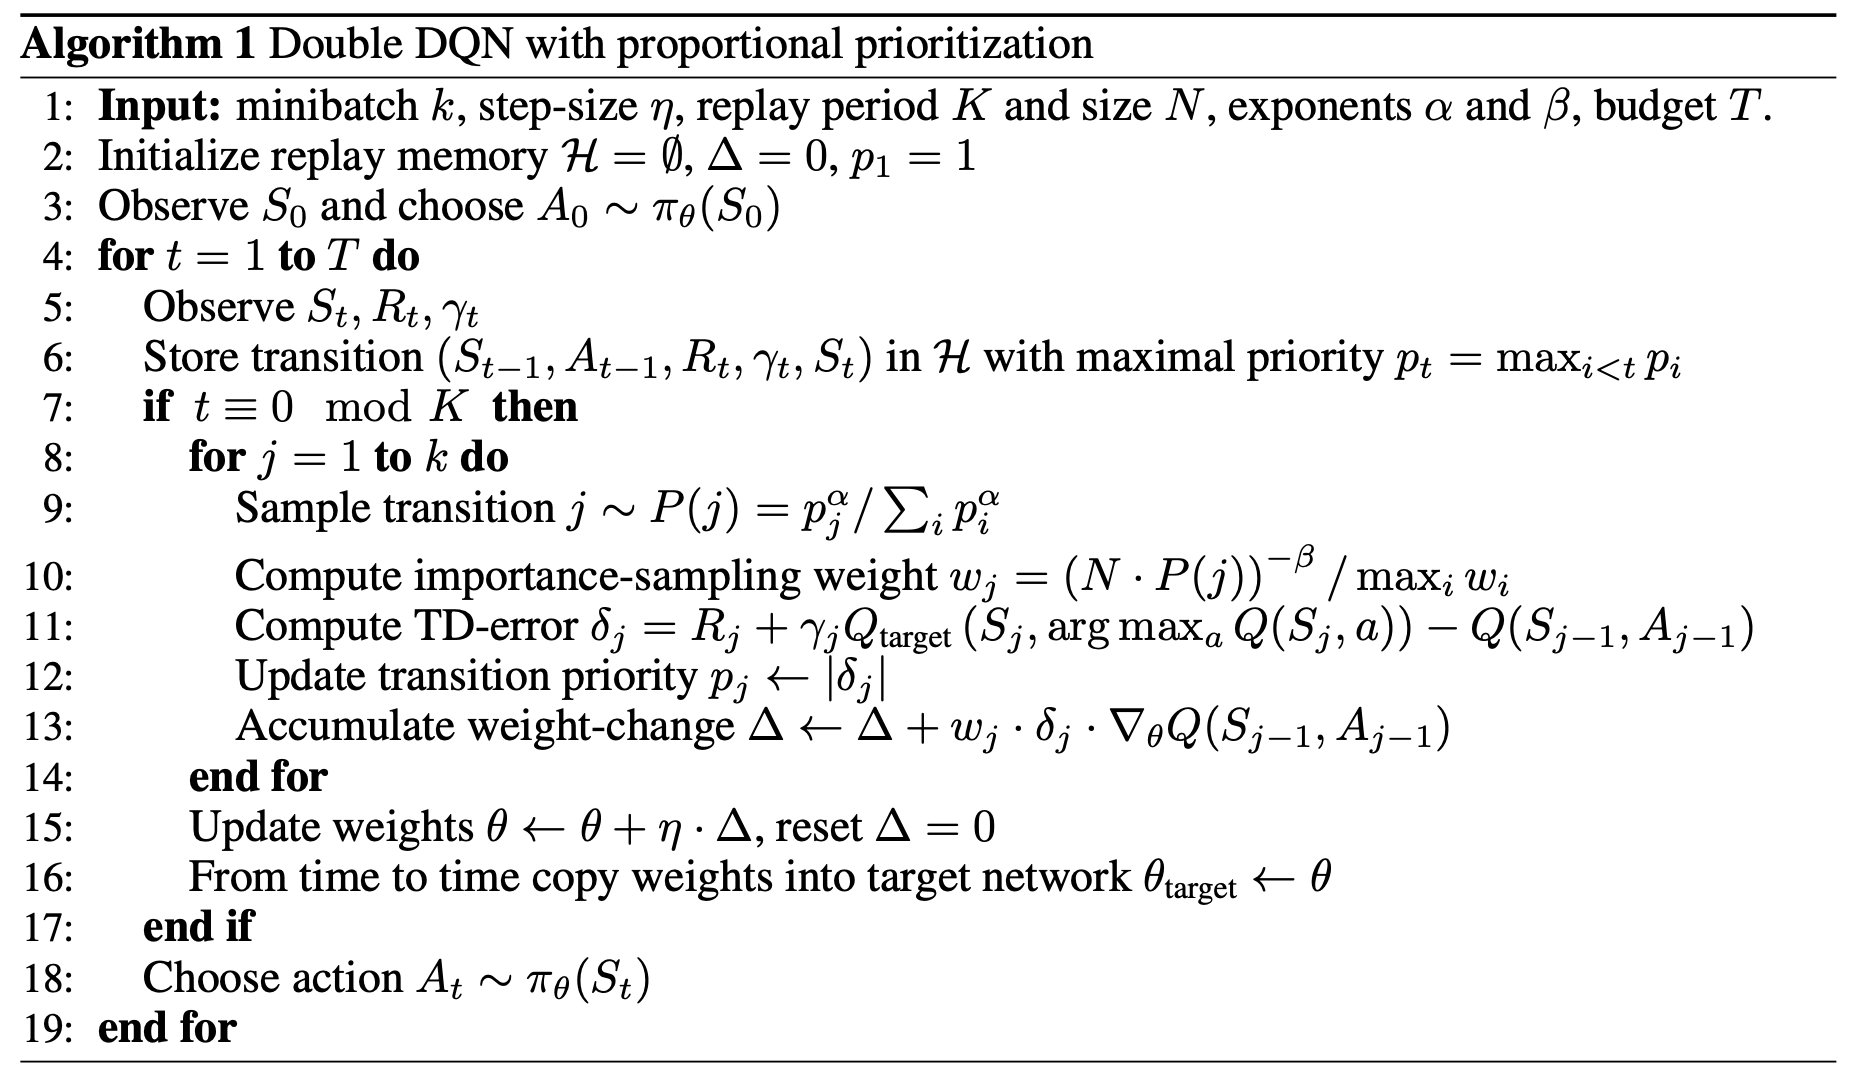

Ape-X에서 기본이 되는 Prioritized Replay Buffer의 알고리즘입니다.

transition을 샘플링할때 각 샘플링의 우선순위 값(위 알고리즘에서는 td-error를 우선순위 값으로 사용)을 가져오고 이 값을 확률로 만들어 줍니다. 여기서 alpha는 (0, 1)값을 갖게 되고, 0으로 갈수록 이 우선순위값을 사용하지 않고 모두 같은 확률로, 1로 갈수록 우선순위 값을 사용하게 됩니다.

이러한 방식으로 transition을 뽑게되면 이 또한 correlation 문제가 발생할 수 있는데, 이를 보상하기 위해 Importance Sampling weight를 도입합니다. uniform하게 뽑을경우의 확률은 1/N이고 우선순위에 따른 경우 확률은 P(j)이므로 나눠주게되어 알고리즘과 같은 식이 나오게 됩니다. 여기서도 (0, 1)값을 갖는 beta를 도입하여서 이 Importance sampling을 얼마나 강하게 할 것인지 정해주게 됩니다.

우선순위 값을 샘플링을 구현시에는 sum tree 구조를 사용하게 됩니다. minibatch를 k개 샘플링 한다고 할 때, k개로 분할하여 각 분할된 곳에서 uniform하게 하나씩 뽑게 되는데, 이 분할된 영역은 우선순위 값의 합의 확률로 샘플링 하게 됩니다. sum tree 구조를 사용하게 되면 이 우선순위 값의 합을 O(log N)으로 샘플링 할 수 있습니다. (우선순위를 td-error가 아닌 rank-based로 할 경우는 binary heap 사용)

RLlib에서 구현된 prioritized replay buffer의 sample(), add(), update_priorities() 구현은 다음과 같습니다. [full code](https://github.com/ray-project/ray/blob/b45840737e6973971d276e225c308d5a9137d4c6/rllib/execution/replay_buffer.py)

In [ ]:
@DeveloperAPI
def sample(self, num_items: int, beta: float) -> SampleBatchType:
    """Sample a batch of experiences and return priority weights, indices.
    Args:
        num_items (int): Number of items to sample from this buffer.
        beta (float): To what degree to use importance weights
            (0 - no corrections, 1 - full correction).
    Returns:
        SampleBatchType: Concatenated batch of items including "weights"
            and "batch_indexes" fields denoting IS of each sampled
            transition and original idxes in buffer of sampled experiences.
    """
    assert beta >= 0.0

    idxes = self._sample_proportional(num_items)

    weights = []
    batch_indexes = []
    p_min = self._it_min.min() / self._it_sum.sum()
    max_weight = (p_min * len(self._storage))**(-beta)

    for idx in idxes:
        p_sample = self._it_sum[idx] / self._it_sum.sum()
        weight = (p_sample * len(self._storage))**(-beta)
        count = self._storage[idx].count
        # If zero-padded, count will not be the actual batch size of the
        # data.
        if isinstance(self._storage[idx], SampleBatch) and \
                self._storage[idx].zero_padded:
            actual_size = self._storage[idx].max_seq_len
        else:
            actual_size = count
        weights.extend([weight / max_weight] * actual_size)
        batch_indexes.extend([idx] * actual_size)
        self._num_timesteps_sampled += count
    batch = self._encode_sample(idxes)

    # Note: prioritization is not supported in lockstep replay mode.
    if isinstance(batch, SampleBatch):
        batch["weights"] = np.array(weights)
        batch["batch_indexes"] = np.array(batch_indexes)

    return batch

In [ ]:
@DeveloperAPI
def add(self, item: SampleBatchType, weight: float) -> None:
    idx = self._next_idx
    super(PrioritizedReplayBuffer, self).add(item, weight)
    if weight is None:
        weight = self._max_priority
    self._it_sum[idx] = weight**self._alpha
    self._it_min[idx] = weight**self._alpha

In [ ]:
@DeveloperAPI
def update_priorities(self, idxes: List[int],
                        priorities: List[float]) -> None:
    """Update priorities of sampled transitions.
    sets priority of transition at index idxes[i] in buffer
    to priorities[i].
    Parameters
    ----------
    idxes: [int]
        List of idxes of sampled transitions
    priorities: [float]
        List of updated priorities corresponding to
        transitions at the sampled idxes denoted by
        variable `idxes`.
    """
    assert len(idxes) == len(priorities)
    for idx, priority in zip(idxes, priorities):
        assert priority > 0
        assert 0 <= idx < len(self._storage)
        delta = priority**self._alpha - self._it_sum[idx]
        self._prio_change_stats.push(delta)
        self._it_sum[idx] = priority**self._alpha
        self._it_min[idx] = priority**self._alpha

        self._max_priority = max(self._max_priority, priority)